In [1]:
cd /content/drive/MyDrive/Dog-breed-classifier

/content/drive/MyDrive/Dog-breed-classifier


In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

In [3]:
# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train/sample')
valid_files, valid_targets = load_dataset('dogImages/valid/sample')
test_files, test_targets = load_dataset('dogImages/test/sample')

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/sample/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 55 total human images.


Number of faces detected: 1


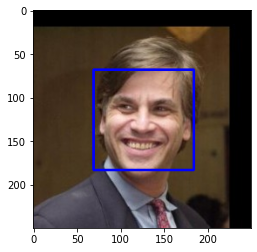

In [5]:
## Detecting Humans

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [6]:
## Human Face Detector
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [7]:
human_files_short = human_files[:50]
dog_files_short = train_files[:50]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_detected = sum([face_detector(human_img) for human_img in human_files_short])
dog_detected = sum([face_detector(dog_img) for dog_img in dog_files_short])

print(f'Percentage of human detected in human images is {human_detected}%')
print(f'Percentage of human detected in dog images is {dog_detected}%')

Percentage of human detected in human images is 50%
Percentage of human detected in dog images is 24%


In [8]:
## Detect Dogs
from keras.applications.resnet import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


In [9]:
## Data Preprocessing

from keras.preprocessing import image                  
from tqdm import tqdm
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
## Function to make predictions

from keras.applications.resnet import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [12]:
## Assessing the dog detector

### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_detected = sum([dog_detector(human_img) for human_img in human_files_short])
dog_detected = sum([dog_detector(dog_img) for dog_img in dog_files_short])

print(f'Percentage of dog detected in human images is {human_detected}%')
print(f'Percentage of dog detected in dog images is {dog_detected}%')

Percentage of dog detected in human images is 0%
Percentage of dog detected in dog images is 97%


In [13]:
## Creating a CNN to classify Dog Breeds

## data Pre-Processing
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 153/153 [00:01<00:00, 102.60it/s]


In [14]:
## constructing a CNN model

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(133,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [15]:
## Compiling the Model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
## Training the CNN Model
from keras.callbacks import ModelCheckpoint
epochs = 5
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5
59/59 [==============================] - ETA: 0s - loss: 3.4972 - accuracy: 0.0534
Epoch 00001: val_loss improved from inf to 3.01372, saving model to saved_models/weights.best.from_scratch.hdf5
59/59 [==============================] - 47s 780ms/step - loss: 3.4972 - accuracy: 0.0534 - val_loss: 3.0137 - val_accuracy: 0.0556
Epoch 2/5
59/59 [==============================] - ETA: 0s - loss: 3.0299 - accuracy: 0.0687
Epoch 00002: val_loss improved from 3.01372 to 2.99715, saving model to saved_models/weights.best.from_scratch.hdf5
59/59 [==============================] - 41s 690ms/step - loss: 3.0299 - accuracy: 0.0687 - val_loss: 2.9971 - val_accuracy: 0.0694
Epoch 3/5
59/59 [==============================] - ETA: 0s - loss: 3.0095 - accuracy: 0.0517
Epoch 00003: val_loss did not improve from 2.99715
59/59 [==============================] - 39s 668ms/step - loss: 3.0095 - accuracy: 0.0517 - val_loss: 2.9981 - val_accuracy: 0.0556
Epoch 4/5
59/59 [=============================

In [19]:
## Transfer Learning

In [20]:
import requests
url = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz'
r = requests.get(url)
with open('DogResnet50Data.npz', 'wb') as f:
    f.write(r.content)


In [21]:
bottleneck_features = np.load('DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

train_Resnet50 = train_Resnet50[:1179]
valid_Resnet50 = valid_Resnet50[:144]
test_Resnet50 = test_Resnet50[:1179]

In [22]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dropout(0.3))
Resnet50_model.add(Dense(1024,activation='relu'))
Resnet50_model.add(Dropout(0.4))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 133)               136325    
                                                                 
Total params: 2,234,501
Trainable params: 2,234,501
Non-trainable params: 0
____________________________________________

In [23]:
#Compile the model using RMSProp
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [24]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 4.3064 - accuracy: 0.0424
Epoch 00001: val_loss improved from inf to 3.24867, saving model to saved_models/weights.best.Resnet50.hdf5
59/59 [==============================] - 3s 43ms/step - loss: 4.3064 - accuracy: 0.0424 - val_loss: 3.2487 - val_accuracy: 0.0347
Epoch 2/20
58/59 [============================>.] - ETA: 0s - loss: 3.1214 - accuracy: 0.0983
Epoch 00002: val_loss improved from 3.24867 to 3.21847, saving model to saved_models/weights.best.Resnet50.hdf5
59/59 [==============================] - 2s 32ms/step - loss: 3.1271 - accuracy: 0.0984 - val_loss: 3.2185 - val_accuracy: 0.0833
Epoch 3/20
59/59 [==============================] - ETA: 0s - loss: 2.8891 - accuracy: 0.1450
Epoch 00003: val_loss did not improve from 3.21847
59/59 [==============================] - 2s 29ms/step - loss: 2.8891 - accuracy: 0.1450 - val_loss: 3.3199 - val_accuracy: 0.0694
Epoch 4/20
59/59 [==============================] - ETA: 

In [25]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [26]:
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.0000%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [41]:
## A function that takes a path to an image as input
## and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    name = dog_names[np.argmax(predicted_vector)]
    return name.split('.')[-1]
    

In [42]:
### Implementing the dog detector function
def detector(img_path):
    if dog_detector(img_path) or face_detector(img_path):
        return Resnet50_predict_breed(img_path)
    else: 
        return "No dog or human found"

In [43]:
def show_image(img_path):
    img = cv2.imread(img_path)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)
    plt.show()

def detector_test(img_path):
    label = img_path.split('/')[-1]
    print(f'Showing image {label}')
    show_image(img_path)
    
    prediction = detector(img_path) 
    print(f'Model predicted {prediction} \n\n **** \n')
    

In [44]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  

In [45]:
from extract_bottleneck_features import *

In [47]:
## Execute your algorithm from Step 6 on
## at least 6 images on your computer.

# detector_test('dogImages/train/sample/005.Alaskan_malamute/Alaskan_malamute_00303.jpg')
# detector_test('/dogImages/train/sample/014.Basenji/Basenji_00956.jpg')
# detector_test('/dogImages/train/sample/018.Beauceron/Beauceron_01283.jpg')
# detector_test(human_files[34])
# detector_test(human_files[91])
# detector_test('images/sample_cnn.png')